In [37]:
from helper import *
from qpixl import *
from QPIXL_qiskit.qpixl_parallel import decodeParallelQPIXL
from QPIXL_qiskit.qpixl_parallel import cFRQI as cFRQI_parallel
import qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import *
from qiskit_aer import StatevectorSimulator
import matplotlib.pyplot as plt
from matplotlib import animation
from PIL import Image
from ipywidgets import interact, widgets
from IPython.display import display, clear_output
import os
from itertools import chain
import cv2
import warnings
import soundfile
from playsound3 import playsound
import cirq
import qutip as qt

from qiskit.circuit import ParameterVector

from qiskit.quantum_info import partial_trace, entropy
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer, AerSimulator
from scipy.optimize import minimize
from functools import partial
from qiskit import QuantumRegister, ClassicalRegister

warnings.filterwarnings('ignore')

backend = StatevectorSimulator(method="statevector")


# Real-valued Data Processing With QPIXL for art, music and beyond
This notebook goes through an embedding known as the FRQI-QPIXL framework, which we have implemented in an easy to deploy set of modules for use in qiskit and pennylane  (Amankwah et al., May 2022, https://www.nature.com/articles/s41598-022-11024-y ). Please look at the ```readme.md``` file for usage and setup of the environment. 


- Contents
    - Introduction
    - QPIXL
    -  Usage examples
        - Images
        - Audio

# Introduction

## Issues with near term machines
The depth (and connectivity) of a circuit completely determines how well it can be implemented on existing hardware. The killing blow to most
algorithms is that they require fully connected and very deep circuits (which get decomposed to even deeper circuits with limited gatesets). 
Due to non-zero error rates, the probability that at least an error has occurred throughout the run of a circuit eventually becomes 1. This can
be mitigated, but at some point it can't be done. This is why short circuits for flexible data embeddings are so important.

## Images and audio in quantum computing
Although quantum computers have a more obvious to see advantage in quantum tasks, nonetheless it is thought that we can see some advantages in tasks involving
classical data loaded onto a quantum computer. Although pictures may not be 'the' data-type that will see an advantage from quantum computing, it is nonetheless 
the case that a lot of data can be input in an image-like format, and studying pictoral algorithms is definitely way easier on the eyes than pure data-driven tasks! 
Also, with a quantum state representing an image, you can see the results of any quantum transformation of the picture as a new picture! Of course, it needs to be 
seen from many 'angles', but maybe it can help with visualizing what these are. Audio equivalently can be mapped in this way. 

# QPIXL

Why do we need another type of embedding in the mix? QPIXL is a framework to decompose popular image encodings such as FRQI, NEQR and their improved counterparts. 
It works by optimally decomposing the gates, and removing any 0 angles that are found. Thanks to the optimal decomposition
the quantum gates can then be further reduced by removing pairs of CNOTS that used to be interwoven by rotation gates. 
They cancel out and become the identity. The code can be seen in the cell below:

In [3]:
def cFRQI_demo(a, compression):
    """    Takes a standard image in a numpy array (so that the matrix looks like
    the image you want if you picture the pixels) and returns the QPIXL
    compressed FRQI circuit. The compression ratio determines
    how many gates will be filtered and then cancelled out. Made into code from this paper:
    https://www.nature.com/articles/s41598-022-11024-y

    Args:
        a (np.array): numpy array of image, must be flattened and padded with zeros up to a power of two
        compression (float): number between 0 an 100, where 0 is no compression and 100 is no image

    Returns:
        QuantumCircuit: qiskit circuit that prepared the encoded image
    """
    a = convertToAngles(a) # convert grayscale to angles
    a = preprocess_image(a) # need to flatten the transpose for easier decoding, 
                            # only really necessary if you want to recover an image.
                            # for classification tasks etc. transpose isn't required.
    n = len(a)
    k = ilog2(n)
    a = 2*a 
    a = sfwht(a)
    a = grayPermutation(a) 
    a_sort_ind = np.argsort(np.abs(a))
    # set smallest absolute values of a to zero according to compression param
    cutoff = int((compression / 100.0) * n)
    for it in a_sort_ind[:cutoff]:
        a[it] = 0
    
    # Construct FRQI circuit
    dataqbits = qiskit.QuantumRegister(k,'storage qubits')
    encodingqubit = qiskit.QuantumRegister(1,'encoding qubit')
    circuit = QuantumCircuit(dataqbits, encodingqubit)
    
    # Data qubits
    circuit.h(dataqbits)

    ctrl, pc, i = 0, 0, 0
    while i < (2**k):
        pc = int(0) # Reset the parity check
        if a[i] != 0:
            circuit.ry(a[i],encodingqubit)  #normally would just be an ry gate 
        # Loop over sequence of consecutive zero angles to cancel out CNOTS (or rather, to not include them)
        if i == ((2**k) - 1):
            ctrl=0
        else:
            ctrl = grayCode(i) ^ grayCode(i+1)
            ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
        pc ^= (2**ctrl) # Update parity check
        i += 1
        while i < (2**k) and a[i] == 0:
            # Compute control qubit
            if i == ((2**k) - 1):
                ctrl=0
            else:
                ctrl = grayCode(i) ^ grayCode(i+1)
                ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
            pc ^= (2**ctrl) # Update parity check
            i += 1              
        for j in range(k):
            if (pc >> j)  &  1:
                circuit.cx(dataqbits[j], encodingqubit[0])      
    circuit.reverse_bits()
    return circuit
circ = cFRQI_demo(np.array([0,1,2,3,4,5,6,7]), 0)
circ.draw(fold=150,vertical_compression='high')

┌───┐                                                                       
storage qubits_0: ───┤ H ├─────────────────────────────────────────────■──────────────────────■──
                     ├───┤                                             │                      │  
storage qubits_1: ───┤ H ├───────────────────────■─────────────────────┼────■─────────────────┼──
                     ├───┤                       │                     │    │                 │  
storage qubits_2: ───┤ H ├─────■─────────────────┼────■────────────────┼────┼─────────────────┼──
                  ┌──┴───┴──┐┌─┴─┐┌───────────┐┌─┴─┐┌─┴─┐┌──────────┐┌─┴─┐┌─┴─┐┌───────────┐┌─┴─┐
  encoding qubit: ┤ Ry(π/2) ├┤ X ├┤ Ry(-π/14) ├┤ X ├┤ X ├┤ Ry(-π/7) ├┤ X ├┤ X ├┤ Ry(-2π/7) ├┤ X ├
                  └─────────┘└───┘└───────────┘└───┘└───┘└──────────┘└───┘└───┘└───────────┘└───┘

This can be used to encode and see images! But to do this, you need to use the function that encodes the image into a circuit.
The circuit looks deep, but it is only (number_of_samples) deep, the encoding this is based on is (number_of_samples)^2, so a significant polynomial improvement on encoding efficiency.  

# Standard encoding with potential compression demo

Still, it is very deep, so what the authors found out is that you can cut the angles off under some threshold and still get some quality, which allows you to remove pairs of cnots and the rotation gates - and greatly reduce the circuit depth! 
An example of how this looks is below. 

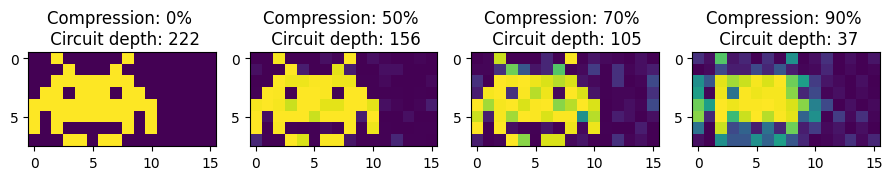

In [4]:
img = examples().space
shape = img.shape # save this for the reconstruction!

comp_images = []
labels = []
for i in [0,50,70,90]:
    comp_str = "Compression: "+str(i)+"% \n"
    qc = cFRQI(img,i)
    job = backend.run(qc)
    depth_str = " Circuit depth: "+str( qc.depth())
    #### Just for show
    sv = np.real(job.result().get_statevector())
    imgt= decodeAngQPIXL(sv, qc,1)#1 because we are not using parallel QPIXL
    comp_images.append(reconstruct_img(imgt, shape).T)
    labels.append(comp_str+depth_str)

fig = plt.figure(figsize=(9, 4))
columns = 4
rows = 1
for i in range(0, columns*rows ):
    img = comp_images[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.title(labels[i])
plt.tight_layout()
plt.show()

# An idea of how to mix in an algorithm
Here is a small example of how you might mix in an algorithm, note that decoding requires that you trace out the algorithmic qubits (or not, if you want that effect)

In [5]:
def cFRQI_with_alg_demo(a, compression):
    """    Takes a standard image in a numpy array (so that the matrix looks like
    the image you want if you picture the pixels) and returns the QPIXL
    compressed FRQI circuit. The compression ratio determines
    how many gates will be filtered and then cancelled out. Made into code from this paper:
    https://www.nature.com/articles/s41598-022-11024-y

    Args:
        a (np.array): numpy array of image, must be flattened and padded with zeros up to a power of two
        compression (float): number between 0 an 100, where 0 is no compression and 100 is no image

    Returns:
        QuantumCircuit: qiskit circuit that prepared the encoded image
    """
    a = convertToAngles(a) # convert grayscale to angles
    a = preprocess_image(a) # need to flatten the transpose for easier decoding, 
                            # only really necessary if you want to recover an image.
                            # for classification tasks etc. transpose isn't required.
    n = len(a)
    k = ilog2(n)
    a = 2*a 
    a = sfwht(a)
    a = grayPermutation(a) 
    a_sort_ind = np.argsort(np.abs(a))
    # set smallest absolute values of a to zero according to compression param
    cutoff = int((compression / 100.0) * n)
    for it in a_sort_ind[:cutoff]:
        a[it] = 0
    
    # Construct FRQI circuit
    dataqbits = qiskit.QuantumRegister(k,'storage qubits')
    encodingqubit = qiskit.QuantumRegister(1,'encoding qubit')
    algorithmqubit = qiskit.QuantumRegister(1,'algorithm qubits') #OPTIONAL 
                              #additional qubit to do interesting stuff with 
    circuit = QuantumCircuit(dataqbits, encodingqubit, algorithmqubit)
    
    # Data qubits
    circuit.h(dataqbits)

    ctrl, pc, i = 0, 0, 0
    while i < (2**k):
        pc = int(0) # Reset the parity check
        if a[i] != 0:
            circuit.unitary(np.array([[np.cos(a[i]), -1j*np.sin(a[i])],
                                     [-1j*np.sin(a[i]), np.cos(a[i])]]), algorithmqubit[0], label=f'alg_{i}')
            circuit.cry(a[i],algorithmqubit,encodingqubit)  #normally would just be an ry gate 
        # Loop over sequence of consecutive zero angles to cancel out CNOTS (or rather, to not include them)
        if i == ((2**k) - 1):
            ctrl=0
        else:
            ctrl = grayCode(i) ^ grayCode(i+1)
            ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
        pc ^= (2**ctrl) # Update parity check
        i += 1
        while i < (2**k) and a[i] == 0:
            # Compute control qubit
            if i == ((2**k) - 1):
                ctrl=0
            else:
                ctrl = grayCode(i) ^ grayCode(i+1)
                ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
            pc ^= (2**ctrl) # Update parity check
            i += 1              
        for j in range(k):
            if (pc >> j)  &  1:
                circuit.cx(dataqbits[j], encodingqubit[0])      
    circuit.reverse_bits()
    return circuit
circ = cFRQI_with_alg_demo(np.array([0,1,2,3,4,5,6,7]), 0)
circ.draw(fold=150,vertical_compression='high')

┌───┐                                                                                             
storage qubits_0: ──┤ H ├─────────────────────────────────────────────────────────────────■────────────────────────■──
                    ├───┤                                                                 │                        │  
storage qubits_1: ──┤ H ├───────────────────────────────────────■─────────────────────────┼──────■─────────────────┼──
                    ├───┤                                       │                         │      │                 │  
storage qubits_2: ──┤ H ├─────────────────■─────────────────────┼──────■──────────────────┼──────┼─────────────────┼──
                    └───┘  ┌─────────┐  ┌─┴─┐  ┌───────────┐  ┌─┴─┐  ┌─┴─┐┌──────────┐  ┌─┴─┐  ┌─┴─┐┌───────────┐┌─┴─┐
  encoding qubit: ─────────┤ Ry(π/2) ├──┤ X ├──┤ Ry(-π/14) ├──┤ X ├──┤ X ├┤ Ry(-π/7) ├──┤ X ├──┤ X ├┤ Ry(-2π/7) ├┤ X ├
                  ┌───────┐└────┬────┘┌─┴───┴─┐└─────┬─────┘┌─┴───┴─┐└───┘└────┬─────┘┌─┴───┴─┐└───┘└─────┬─────┘└───┘
algorithm qubits: ┤ alg_0 ├─────■─────┤ alg_1 ├──────■──────┤ alg_3 ├──────────■──────┤ alg_7 ├───────────■───────────
                  └───────┘           └───────┘             └───────┘                 └───────┘

In [6]:
### An example of putting pattern and pattern2 where alg_0, alg_1, etc. are
def plot_interactive_rot(ang1,ang2):#, qubit, gate):
    example = examples().space
    def pattern(circ):
        circ.crx(ang1,1,0)
    def pattern2(circ):
        circ.crx(ang2,1,0)
    qc = cFRQIangs(example,0,pattern,pattern2)
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeAngQPIXL(sv,qc,2)
    example = reconstruct_img(example, examples().space.shape).T
    plt.imshow(example)

gates = ['RY','RX']
interact(plot_interactive_rot,ang1=(-np.pi/5,np.pi/5,0.01),ang2=(-np.pi/5,np.pi/5,0.01))#,qubit=(0,7),gate=gates)


interactive(children=(FloatSlider(value=-0.008318530717958628, description='ang1', max=0.6283185307179586, min…

<function __main__.plot_interactive_rot(ang1, ang2)>

You can see that the quality for the high resolution image is much better than that of the low resolution image, but the fine details are lost all the same. 

# Appending gates to the end of the circuit
You can imagine that you can now do some quantum operation on this encoded state!!!
So what do a global rotation do to our image? Below are exampled for RX and RY rotations applied to each qubit.

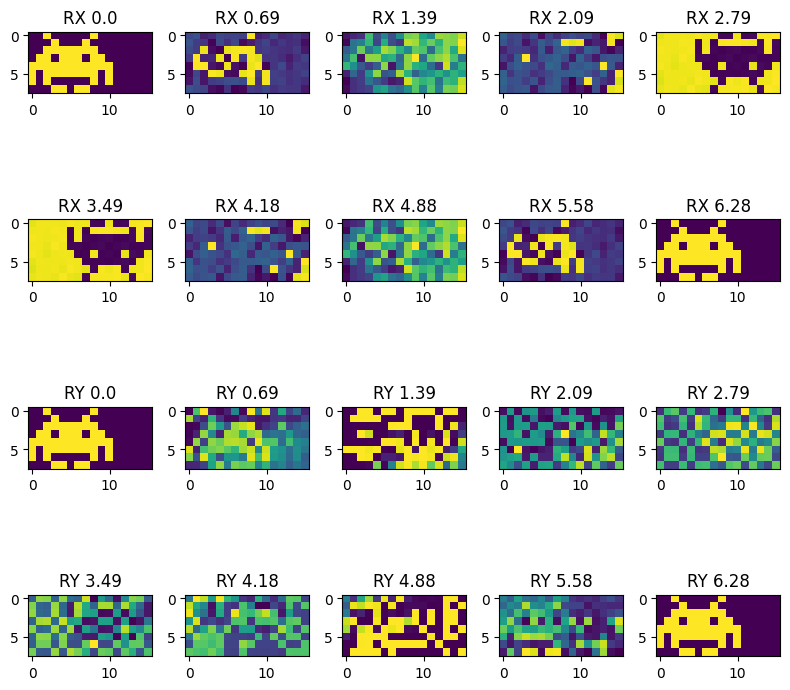

In [7]:
#### Single Picture 'Photoshop'
labels  = []
gen_mats = []
for i in np.linspace(0,2*np.pi,10):
    example = examples().space
    shape = example.shape
    qc = cFRQI(example,0)
    qc.rx(i,range(qc.num_qubits)) ### apply RX to everything
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, shape).T
    labels.append('RX '+str(i)[0:4])
    gen_mats.append(example)

for i in np.linspace(0,2*np.pi,10):
    example = examples().space
    qc = cFRQI(example,0)
    qc.ry(i,range(qc.num_qubits)) ### apply RY to everything
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, shape).T
    labels.append('RY '+str(i)[0:4])
    gen_mats.append(example)

fig = plt.figure(figsize=(8, 8))
columns = 5
rows = 4
for i in range(0, columns*rows ):
    img = gen_mats[i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.title(labels[i])
plt.tight_layout()
plt.show()



Or you can imagine what happens applying it only to one qubit! Remeber that qubit 0 is the one that has all the CNOT targets and rotations.

In [8]:
def plot_interactive_rot(ang, qubit, gate):
    example = examples().space
    qc = cFRQI(example,0)
    if gate == 'RY':
        qc.ry(ang,qubit) 
    if gate == 'RX':
        qc.rx(ang,qubit) ### apply RX to everything
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, examples().space.shape).T
    plt.imshow(example)

gates = ['RY','RX']
interact(plot_interactive_rot,ang=(0,np.pi,0.2),qubit=(0,7),gate=gates)


interactive(children=(FloatSlider(value=1.4000000000000001, description='ang', max=3.141592653589793, step=0.2…

<function __main__.plot_interactive_rot(ang, qubit, gate)>

In [9]:
def plot_interactive_cnot(control, target):
    example = examples().space
    qc = cFRQI(example,0)
    if control != target:
        qc.cx(control,target) ### apply RX to everything
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, examples().space.shape).T
    plt.imshow(example)

interact(plot_interactive_cnot,control=(0,7),target=(0,7))


interactive(children=(IntSlider(value=3, description='control', max=7), IntSlider(value=3, description='target…

<function __main__.plot_interactive_cnot(control, target)>

In [10]:
### Example of different gates' effects  
def plot_interactive_rot(ang, qubit, gate):
    img1 = examples().invader
    shape1 = img1.shape#(64,64)
    img2 = examples().space
    shape2 = img2.shape
    img1 = convertToAngles(pad_0(img1))
    img2 = convertToAngles(pad_0(img2))
    img2,img1=img1,img2
    qc1 = cFRQI(img1,0)
    qc2 = cFRQI(img2,0)
    big_qc = QuantumCircuit(qc1.width()+qc2.width())
    big_qc = big_qc.compose(qc1, qubits=list(range(qc1.width())))
    big_qc = big_qc.compose(qc2, qubits=list(range(qc1.width(),qc1.width()+qc2.width())))
    ### INSERT DESIRED GATES HERE
    #big_qc.x(range(qc1.width(),qc1.width()+qc2.width()))
    for i in range(qubit, qc2.width()):
        if gate == 'CRX':
            big_qc.crx(ang,i, i+qc1.width())
        if gate == 'CRY':
            big_qc.cry(ang,i, i+qc1.width())
        if gate == 'SWAP':
            big_qc.swap(i, i+qc1.width())
        # Example of CNOT between two images
    #########################
    job = backend.run(big_qc)
    sv = np.real(job.result().get_statevector())
    img = decodeQPIXL(sv, state_to_prob = np.real)#Image 1 is the one that is recovered
    img = reconstruct_img(img, shape1).T
    plt.imshow(img)

gates = ['CRX','CRY','SWAP']
interact(plot_interactive_rot,ang=(0,2*np.pi,0.2),qubit=(0,8),gate=gates)


interactive(children=(FloatSlider(value=3.0, description='ang', max=6.283185307179586, step=0.2), IntSlider(va…

<function __main__.plot_interactive_rot(ang, qubit, gate)>

In [30]:
# Write a code in numpy that computes the partial trace of a matrix


nq = 6

state = np.random.rand(2**nq) + 1j * np.random.rand(2**nq)
state = state / np.linalg.norm(state)
state = np.zeros(2**nq)
state[0] = 1
rho = np.outer(state, state.conjugate())

print(rho.shape)

def ptrace(state, index):
    
    q_new_rho = partial_trace(state, index)

    return q_new_rho


new_rho = np.array(ptrace(state,  [1,2,3]))
print(new_rho.shape)

def schmidt_decompose(rho):
    """Computes the Schmidt decomposition of a density matrix rho.

    Args:
        rho (np.ndarray): The density matrix to decompose.

    Returns:
        tuple: A tuple containing the Schmidt coefficients and the Schmidt basis.
    """
    # Compute the eigenvalues and eigenvectors of the density matrix
    eigenvalues, eigenvectors = np.linalg.eigh(rho)

    # Sort the eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Compute the Schmidt coefficients
    schmidt_coefficients = np.sqrt(sorted_eigenvalues)

    # Compute the Schmidt basis
    schmidt_basis = sorted_eigenvectors

    return schmidt_coefficients, schmidt_basis

def srank(rho):
    """Computes the rank of a density matrix rho.

    Args:
        rho (np.ndarray): The density matrix to compute the rank of.

    Returns:
        int: The rank of the density matrix.
    """
    # Compute the eigenvalues of the density matrix
    eigenvalues = np.linalg.eigvals(rho)

    # Count the number of non-zero eigenvalues
    rank = np.sum(eigenvalues > 1e-10)

    return rank



srank(new_rho)



(64, 64)
(8, 8)


1

In [12]:
def layer_circuit_vqe(n_qubits=2, n_layers=1, param_name='theta', analog_tqg=False):

    """
    Creates a layer circuit for VQE with the specified number of qubits and layers.
    Args:
        n_qubits (int): Number of qubits in the circuit.
        n_layers (int): Number of layers in the circuit.
        param_name (str): Name of the parameter for the rotation angles.
        analog_tqg (bool): If True, use analog TQG. Default is False.
    Returns:
        qc (QuantumCircuit): The constructed quantum circuit.
        theta_param (ParameterVector): The parameter vector for the rotation angles.
        N (int): The total number of parameters in the circuit.
    """

    qc = QuantumCircuit(n_qubits)

    if analog_tqg:
        N = int(n_qubits * (n_qubits - 1) / 2 + 2 * n_qubits) * n_layers
        # N = 2*n_qubits*n_layers
    else:
        N = 4*n_qubits * n_layers

    theta_param = ParameterVector(param_name, length=N)
    counter = 0
    for k in range(n_layers):
        qc.barrier()
        for iq in range(n_qubits):
            qc.rx(theta_param[counter], iq)
            qc.rz(theta_param[counter + 1], iq)
        #    qc.h(iq)
            counter += 2
            
        for iq in range(n_qubits-1):
            qc.cz(iq, iq+1)

        for iq in range(n_qubits):
            qc.rx(theta_param[counter], iq)
            qc.rz(theta_param[counter + 1], iq)
            counter += 2


    return qc, theta_param, N

In [13]:

def cost_function(theta, qc, n_qubits, index):
    """
    Computes the cost function for VQE.
    Args:
        theta (np.ndarray): The parameter vector for the rotation angles.
        qc (QuantumCircuit): The quantum circuit.
        n_qubits (int): Number of qubits in the circuit.
        n_layers (int): Number of layers in the circuit.
        analog_tqg (bool): If True, use analog TQG. Default is False.
    Returns:
        float: The cost function value.
    """
    # Create a new circuit with the same number of qubits
    new_circuit = QuantumCircuit(n_qubits)

    # Add the original circuit to the new circuit
    new_circuit.append(qc, range(n_qubits))

    # Bind the parameters to the circuit
    new_circuit = new_circuit.assign_parameters(theta)


    # Simulate the circuit
    backend = StatevectorSimulator(method="statevector")
    new_circuit = transpile(new_circuit, AerSimulator())
    job = backend.run(new_circuit)
    result = job.result()
    statevector = result.get_statevector()

    #print(statevector.shape)

    #dmatrix = DensityMatrix(statevector, dims=(2,) * n_qubits)
    rho_red = ptrace(statevector, index)

    #print(np.round(rho_red,2))

    #print(np.array(rho_red).shape)
    
    entropy_value = entropy(rho_red)

    # Compute the cost function value
    cost_value = -entropy_value

    return np.real(cost_value)

In [9]:
# Create Adam algortithm

class AdamOptimizer:
    def __init__(self, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0

    def update(self, params, grads):
        # Initialize m and v if it's the first time
        if self.m is None:
            self.m = np.zeros_like(params)
        if self.v is None:
            self.v = np.zeros_like(params)

        self.t += 1

        # Update biased first moment estimate
        self.m = self.beta1 * self.m + (1 - self.beta1) * grads
        # Update biased second raw moment estimate
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grads ** 2)

        # Compute bias-corrected first moment estimate
        m_hat = self.m / (1 - self.beta1 ** self.t)
        # Compute bias-corrected second raw moment estimate
        v_hat = self.v / (1 - self.beta2 ** self.t)

        # Update parameters
        params -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

        return params




In [13]:
# Test
n_qubits = 6
n_layers = 3
qc, theta_param, N = layer_circuit_vqe(n_qubits=n_qubits, n_layers=n_layers)
qc.draw('mpl')
index = [0,1,2]

In [ ]:


theta = 2*np.pi*np.random.rand(N)
opt = AdamOptimizer()

def cost(theta):

    return cost_function(theta, qc, n_qubits, index)


def num_grad(theta, eps=1e-8):

    grad_vec = np.zeros(len(theta))

    for i in range(len(theta)): 
        
        evec = np.zeros(len(theta))
        evec[i] = 1
        dcost = (cost(theta + eps*evec) - cost(theta - eps*evec))/(2*eps)

        grad_vec[i] = dcost
        #print(cost(theta + eps*evec))
    return grad_vec    


# maximize cost function
n_iter = 2000
#for i in range(n_iter):
#    theta = opt.update(theta, num_grad(theta))
#print(cost(theta))
res = minimize(cost, theta, method='L-BFGS-B', jac=num_grad, options={'disp': True})
print("Cost function value:", res.fun)
print("Optimized parameters:", res.x)


KeyboardInterrupt: 

# Quantum entanglement of two images
Maybe you can explore the entanglement of two states if you only measure one of the two sates? We show an example of an image mixed with its own transpose by taking CNOTS betweent the two images, but perhaps there are other interesting approaches to take? 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.04927988476219283..1.5707963267948966].


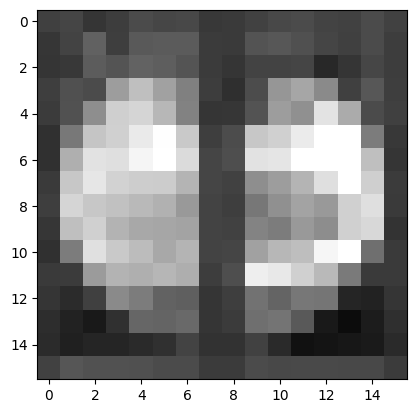

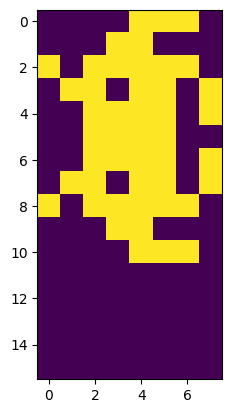

NameError: name 'qc1' is not defined

In [14]:
img1 = Image.open('figures/creation_world.png')
img1 = img1.resize((16,16), Image.Resampling.LANCZOS)
shape1 = (16,16)
# img1 = examples().invader
# shape1 = img1.shape#(64,64)
img2 = examples().space
shape2 = img2.shape


img1 = convertToAngles(pad_0(img1))
img2 = convertToAngles(pad_0(img2))
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
# img2,img1=img1,img2
encode_circ_img1 = cFRQI(img1,80)
encode_circ_img2 = cFRQI(img2,50)
big_qc = QuantumCircuit(qc1.width()+qc2.width(), qc1.width())
# Test
n_qubits = 6
n_layers = 3
qc, theta_param, N = layer_circuit_vqe(n_qubits=n_qubits, n_layers=n_layers)
qc.draw('mpl')
index = [0,1,2]

#big_qc = big_qc.compose(qc1, qubits=list(range(qc1.width()))) 
#big_qc = big_qc.compose(qc2, qubits=list(range(qc1.width(),qc1.width()+qc2.width())))




### INSERT DESIRED GATES HERE
for i in range(qc2.width()):
    #big_qc.h(i)
    big_qc.crx(i*np.pi/qc2.width(),i, i+qc1.width())
    #big_qc.cx(i, i+qc1.width())

big_qc = big_qc.compose(qc1, qubits=list(range(qc1.width()))) 
big_qc = big_qc.compose(qc2, qubits=list(range(qc1.width(),qc1.width()+qc2.width())))
big_qc.barrier()

for i in reversed(range(qc2.width())):
    big_qc.crx(i*np.pi/qc2.width(),i, i+qc1.width())
    big_qc.cx(i, i+qc1.width())
    big_qc.h(i)

#big_qc.measure(range(qc1.width()), range(qc1.width()))

big_qc.draw("mpl", fold=150,vertical_compression='high')
    # Example of CNOT between two image states, as an "entangling operation"
#########################
job = backend.run(big_qc)
sv = np.abs(job.result().get_statevector())
img = decodeQPIXL(sv, state_to_prob = np.abs)#Image 1 is the one that is recovered
img = reconstruct_img(img, shape1)
plt.imshow(img)
plt.show()

In [31]:
def build_image_circuit(img_path_list, var_circ_func, d, compression_list, n_layers):
    """
    Computes the cost function to maximize the entanglement between two images.
    Args:
        theta (np.ndarray): The parameter vector for the rotation angles.
        qc (QuantumCircuit): The quantum circuit.
        n_qubits (int): Number of qubits in the circuit.
        n_layers (int): Number of layers in the circuit.
        analog_tqg (bool): If True, use analog TQG. Default is False.
    Returns:
        float: The cost function value.
    """
    img_circ_size_list = []
    img_circ_list = []

    assert d % 2 == 0

    for i_imgp, img_path in enumerate(img_path_list):
        img = Image.open(img_path)
        img = img.convert('L')
        #img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        #print(img)
        img = img.resize((d,d), Image.Resampling.LANCZOS)

        img_angles = convertToAngles(pad_0(img))
        print(img_angles.shape)
        
        encode_circ_img = cFRQI(img_angles,compression=compression_list[i_imgp])

        img_circ_list.append(encode_circ_img)
        img_circ_size_list.append(encode_circ_img.width())

    big_circ = QuantumCircuit(sum(img_circ_size_list), sum(img_circ_size_list)) 


    # Add the original circuit to the new circuit
    for i, img_circ in enumerate(img_circ_list):
        big_circ.append(img_circ, range(sum(img_circ_size_list[:i]), sum(img_circ_size_list[:i+1])))

    var_circ, _, N_var_params = var_circ_func(n_qubits=sum(img_circ_size_list), n_layers=n_layers)
    assert var_circ.width() <= sum(img_circ_size_list)

    big_circ.append(var_circ, range(var_circ.width()))


    # Bind the parameters to the circuit

    def sample_circ(theta, index):
        
        new_circ = var_circ.assign_parameters(theta)


        # Simulate the circuit
        backend = StatevectorSimulator(method="statevector")
        new_circ = transpile(new_circ, AerSimulator())
        job = backend.run(new_circ)
        result = job.result()
        statevector = result.get_statevector()

        #print(statevector.shape)

        #dmatrix = DensityMatrix(statevector, dims=(2,) * n_qubits)
        rho_red = ptrace(statevector, index)

        print(np.shape(rho_red))

        #print(np.round(rho_red,2))

        #print(np.array(rho_red).shape)
        
        entropy_value = entropy(rho_red)

        # Compute the cost function value
        cost_value = -entropy_value

        return np.real(cost_value), statevector

    return sample_circ, N_var_params

In [33]:
d = 16
n_layers_img = 2
index0 = list(range(int(2*np.log2(d)+1)))
img_path_list = ['figures/00.jpg', 'figures/01.jpg']
run_entropy, N_params = build_image_circuit(img_path_list=img_path_list, var_circ_func=layer_circuit_vqe, d=d, compression_list=[80, 80], n_layers=n_layers_img)
theta0 = 2*np.pi*np.random.randn(N_params)
run_entropy(theta0, index0)

(16, 16)
(16, 16)
(512, 512)


(-1.0292048312331359,
 Statevector([-3.97844480e-04-6.37380517e-04j,
              -8.72730082e-04+1.05559109e-04j,
              -5.58504578e-04+8.02832330e-05j, ...,
               2.76953154e-04-1.57513511e-04j,
               3.30578024e-05-6.44586812e-05j,
               1.02085691e-04+1.99115253e-04j],
             dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2)))

In [35]:
def opt_cost(theta, index):

    return run_entropy(theta, index=index)[0]

def get_statevector(theta, index):
    
    return run_entropy(theta, index=index)[1]

In [ ]:
def callback(x):
    print("Current cost:", opt_cost(x, index0))
    print("Current parameters:", x)
    print("Current statevector:", get_statevector(x, index0))

    # Save the statevector to a file
    np.save('statevector.npy', get_statevector(x, index0))

In [36]:
res = minimize(partial(opt_cost, index=index0), x0=theta0, method='L-BFGS-B', options={'disp': True})

print("Cost function value:", res.fun)
print("Optimized parameters:", res.x)

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)

(512, 512)
[-1.48665446e-04 -4.94363430e-04 -3.57955381e-04 ...  2.52814053e-04
  2.81946246e-05  1.04363237e-04]


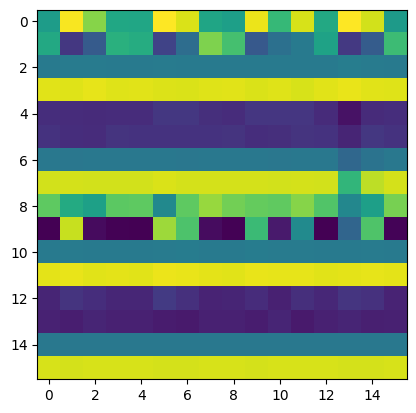

In [38]:
theta_optimized = res.x
entangled_statevector = get_statevector(theta_optimized, index=index0)
print(np.real(entangled_statevector))
img = decodeQPIXL(np.abs(entangled_statevector)**2, state_to_prob = np.real)#Image 1 is the one that is recovered
img = reconstruct_img(img, (d,d))
plt.imshow(img)
plt.show()


## Animations
You can even use it to make animations!

In [ ]:

img = examples().space
shape = img.shape
def plot_interactive_rot(i):
    ang = i/300*2*np.pi
    example = examples().space
    qc = cFRQI(example,0)
    qc.ry(ang,range(qc.width())) 
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, shape).T
    plt.title('RY '+str(ang)[0:4])
    plt.imshow(example)

fig = plt.figure()
ani = animation.FuncAnimation(fig, plot_interactive_rot, interval=30,frames=300)
writergif = animation.PillowWriter(fps=60) 
ani.save('test_gif.gif', writer=writergif)


In [ ]:
def hst(U, V):
    """
    Computes the Hilbert-Schmidt distance between two unitaries U and V.
    """
    q1 = QuantumRegister(U.num_qubits, 'q1')
    q2 = QuantumRegister(V.num_qubits, 'q2')

    circ = QuantumCircuit(q1, q2)

    for i in range(q1.size):
        circ.h(q1[i])

    for i in range(q1.size):
        circ.cx(control_qubit=q1[i], target_qubit=q2[i])

    circ.append(U, q1)
    circ.append(V, q2)

    for i in range(q1.size):
        # print(q1.size-i-1)
        circ.cx(control_qubit=q1[q1.size - i - 1], target_qubit=q2[q1.size - i - 1])

    for i in range(q1.size):
        circ.h(q1[i])

    circ.measure_all()

    return circ

In [ ]:
def power_of_two_qubits(U, V, imag=False, measure=True):  # Circuit that computes Re(UV^dag) or Im(UV^^dag)

    q1 = QuantumRegister(2, 'q1')
    q2 = QuantumRegister(U.num_qubits, 'qU')
    q3 = QuantumRegister(V.num_qubits, 'qV')

    # print(U.num_qubits, V.num_qubits)

    if measure:
        c = ClassicalRegister(1, 'c')
        circ = QuantumCircuit(q1, q2, q3, c)
    else:
        circ = QuantumCircuit(q1, q2, q3)

    circ.h(q1[0])

    circ.cx(q1[0], q1[1])

    for i in range(U.num_qubits):
        circ.h(q2[i])

    for i in range(U.num_qubits):
        circ.cx(q2[i], q3[i])

    circ.append(V.to_gate().control(1, label="CtrlV", ctrl_state=1), qargs=[q1[0], ] + q3[:])
    circ.append(U.to_gate().control(1, label="CtrlU", ctrl_state=0), qargs=[q1[1], ] + q2[:])

    # circ.draw('mpl')

    circ.cx(q1[0], q1[1])

    if imag:
        circ.s(q1[0])
        circ.h(q1[0])
    else:
        circ.h(q1[0])

    if measure:
        circ.measure(q1[0], c[0])

    return circ

![SegmentLocal](figures/test_gif.gif "segment")

How does an image transformation look in an embedding like qpixl? Well, we can interpolate between the angle embeddings of the two images and see! 
We use two little aliens to illustrate how this would look like.

In [ ]:
alien1 = examples().space
shape1 = alien1.shape
alien2 = examples().invader
shape2 = alien2.shape


def plot_interactive_rot(i):
    """Trivial example of an animation where a new state is generated each time.
    It would be more interesting if you did a proper evolution over time and read 
    the state at each point. 

    Args:
        i (time): frame to render in linear interpolation of equation
    """
    t = 100*i/150
    #example = ((100-t)/(100-1)) * alien1 + ((t-1)/(100-1)) * alien2
    qc1 = cFRQI(alien1,0)
    qc2 = cFRQI(alien2,0)
    #qc = cFRQI(example,0)
    
    job = backend.run(qc)
    sv = np.real(job.result().get_statevector())
    example = decodeQPIXL(sv)
    example = reconstruct_img(example, shape1).T
    plt.title('transformation '+str(t)[0:4]+'%')
    plt.imshow(example)

fig = plt.figure()
ani = animation.FuncAnimation(fig, plot_interactive_rot, interval=30,frames=150)
writergif = animation.PillowWriter(fps=45) 
ani.save('transform.gif', writer=writergif)


![SegmentLocal](figures/transform.gif "segment")


# RGB QPXL!
You can of course, encode three different channels separately and recombine in post for cool effects, perhaps by rotating the different channels by different angles, we rotate the image by pi/10 for the green channel and pi/5 for the blue channel.


In [ ]:
# READ IMAGE AND SPLIT
Image_ghost = Image.open('figures/mario_eg.png')
Image_ghost_data = np.asarray(Image_ghost)

red_channel = []
green_channel = []
blue_channel = []

for i in range(len(Image_ghost_data)):
    for j in range(len(Image_ghost_data[0])):
        red_channel.append(Image_ghost_data[i][j][0])

for i in range(len(Image_ghost_data)):
    for j in range(len(Image_ghost_data[0])):
        green_channel.append(Image_ghost_data[i][j][1])

for i in range(len(Image_ghost_data)):
    for j in range(len(Image_ghost_data[0])):
        blue_channel.append(Image_ghost_data[i][j][2])
        

red_channel = np.array(red_channel).reshape(len(Image_ghost_data), len(Image_ghost_data[0]))
green_channel = np.array(green_channel).reshape(len(Image_ghost_data), len(Image_ghost_data[0]))
blue_channel = np.array(blue_channel).reshape(len(Image_ghost_data), len(Image_ghost_data[0]))
chans = [(red_channel), (green_channel), (blue_channel)]


In [ ]:
def plot_interactive_rot(ang1, ang2, ang3,compress):
    encoded_decoded = []
    angs = [ang1,ang2,ang3]
    for i, ang in zip(chans,angs):
        tempi = pad_0(i.T.flatten())
        maxval = np.max(tempi)
        minval = np.min(tempi)
        qc = cFRQI(tempi,compress)
        qc.ry(ang,range(qc.width())) 

        job = backend.run(qc)
        #### Just for show
        sv = np.real(job.result().get_statevector())
        img2 = decodeQPIXL(sv,minval,maxval,scaling=convertToGrayscaleOld)
        encoded_decoded.append(reconstruct_img(img2, (len(Image_ghost_data), len(Image_ghost_data[0]))))

    rgb = np.abs(np.dstack(encoded_decoded))
    plt.imshow( Image.fromarray(np.array(rgb).astype(np.uint8), 'RGB'))
interact(plot_interactive_rot,ang1=(0,2*np.pi,0.1),ang2=(0,2*np.pi,0.1),ang3=(0,2*np.pi,0.1),compress = (0,100,5))


interactive(children=(FloatSlider(value=3.1, description='ang1', max=6.283185307179586), FloatSlider(value=3.1…

<function __main__.plot_interactive_rot(ang1, ang2, ang3, compress)>

# Audio processing
Audio must be sliced and processed in chunks to get any appreciably long sample length. As such, one must be careful to mantain minimum and maximum values between the chunks for the reconstruction. An example process is shown in the below cell, which accepts some patterns to interweave with circuit, as you might do in more depth when mixing an algorithm with the data encoding.   

In [ ]:
### An example function for processing audio adding some interleaving gates (pattern functions) and some gates after the encoding (post processing function)

def process_audio(
    input_file, 
    output_dir, 
    pattern_func, 
    pattern2_func, 
    post_process_func=None, 
    tag="", 
    compression=0,
):
    """
    Processes an audio file by encoding it into a quantum circuit, applying transformations, 
    and performing spectral noise reduction. 

    Args:
        input_file (str): Path to the input audio file.
        output_dir (str): Directory to save the processed audio files.
        pattern_func (function): Function to apply the first pattern to the quantum circuit.
        pattern2_func (function): Function to apply the second pattern to the quantum circuit.
        post_process_func (function, optional): Function to apply additional processing to the quantum circuit. Defaults to None.
        tag (str): Tag to append to the output file names. Defaults to an empty string.
        compression (int): Compression level for the quantum circuit encoding. Defaults to 0.

    Returns:
        None
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    file_name, _ = os.path.splitext(os.path.basename(input_file))
    metadata_file_path = os.path.join(output_dir, f"{file_name}_metadata_{tag}_c{compression}.txt")
    if not os.path.exists(metadata_file_path):
    # Read the input audio file and split, as it would be too large to process in one go
        data, samplerate = soundfile.read(input_file)
        chunk_size = 512
        sections = [pad_0(data[i:i + chunk_size]) for i in range(0, len(data), chunk_size)][:-1] 
        #remove last chunk since it can cause issues due to 0s in padding
        decoded = []

        # Process each audio chunk
        for index, section in enumerate(sections):
            print(f'Processing {file_name} chunk: {index + 1}/{len(sections)}', end='\r')
            normalized_section = section - np.min(section)
            patt1,_ = pattern_func
            patt2,_ = pattern2_func
            qc = cFRQIangs(normalized_section, compression, patt1, patt2) # 
            ### Variant of encoding that has additional code to allow for a 
            ### pattern to be applied in the algorithm qubits

            # Apply post-processing if provided
            if post_process_func is not None:
                post_process_func(qc)

            # Run the quantum circuit and decode the result
            job = backend.run(qc)
            state_vector = np.real(job.result().get_statevector())
            decoded.append(decodeAngQPIXL(
                state=state_vector, 
                qc=qc, 
                length=2, 
                max_pixel_val=section.max(), 
                min_pixel_val=section.min() #Ensures that the audio amplitudes are preserved between chunks
            ))

        # Save the processed audio
        decoded_full = np.array(list(chain.from_iterable(decoded)))
        original_with_pad = np.array(list(chain.from_iterable(sections)))
        soundfile.write(
            os.path.join(output_dir, f"{file_name}_output_{tag}_c{compression}.wav"), 
            decoded_full, 
            samplerate, 
        )
        
def pattern(angle):
    """    Example pattern function that applies a 
    CRX gate to the quantum circuit in the algortihm register.
    Returns a function that takes a circuit and applies the pattern.
    """
    def pattern(circ):
        circ.crx(angle, 1, 0)
    return pattern, angle
def pattern2(angle):
    def pattern(circ):
        circ.cry(angle, 1, 0)
    return pattern, angle 
def post(qubit):
    def post(circ):
        circ.h(qubit)
    return post

wav_files = [f for f in os.listdir('Sample_Material') if f.endswith('.mp3')]
folder_paths = [os.path.join('Sample_Material', os.path.splitext(f)[0]) for f in wav_files]
for file,path in zip(wav_files,folder_paths):
    process_audio(
                os.path.join('Sample_Material', file), 
                path, 
                pattern(np.pi/5), 
                pattern2(np.pi/10),
                post_process_func=post(3),
                compression=90,
                tag="demo", 
                )